<a href="https://colab.research.google.com/github/clayedw/RET-2024/blob/main/binning_with_gaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
#The code below is based off that of LSSTDESC/CCLX and uses that of:
#  Niko Sarcevic
#  nikolina.sarcevic@gmail.com
#  github.com/nikosarcevic
#and
#  Andrina Nicola
#  anicola[at]astro[dot]princeton[dot]edu
#  github.com/Andrina Nicola
#and
#  Elisa Chisari
#  n.e.chisari@uu.nl
#  #  github.com/elisachisari
!pip install -q condacolab
import condacolab

condacolab.install()

!conda install --no-pin pyccl

import pyccl as ccl

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: | / - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



#Tomographic binning of redshift distributions according to Gaussian distributions

This project focuses on analyzing galaxy data across different redshift bins to understand their spatial clustering properties. The project begins by defining a range of redshift values and characterizing the distribution of galaxies using a Smail-type parameterization. This distribution model helps to approximate how galaxies are distributed across different redshifts, influenced by parameters like α and β.

Next, the redshift data is divided into bins defined by specific bin edges. Each bin represents a range of redshift values within which galaxies are categorized. Photometric redshift uncertainties (σ) are also considered, reflecting measurement errors in determining the precise redshift of galaxies.

The core of the project involves binning the galaxy data according to their Gaussian distributions. Each galaxy's contribution to the distribution curve within a bin is determined by integrating the Gaussian probability density function over the bin's range. This step is essential for accurately distributing galaxy data points across bins, accounting for uncertainties in their redshift measurements.

Normalization ensures that the total contribution of galaxy data points across all bins sums to one, maintaining the integrity of the redshift distribution model, and necessary to correctly interpret the clustering properties of galaxies within each bin relative to their true distributions.

Further analysis includes calculating angular power spectra and correlation functions for each redshift bin. These analyses provide insights into the spatial clustering of galaxies at different redshifts, allowing insight into galaxy clustering evolution over cosmic time.

Overall, the project combines theoretical modeling of redshift distributions with observational data analysis techniques to analyze galaxy clustering in the universe, accounting for uncertainties in redshift measurements to hopefully derive meaningful cosmological insights.

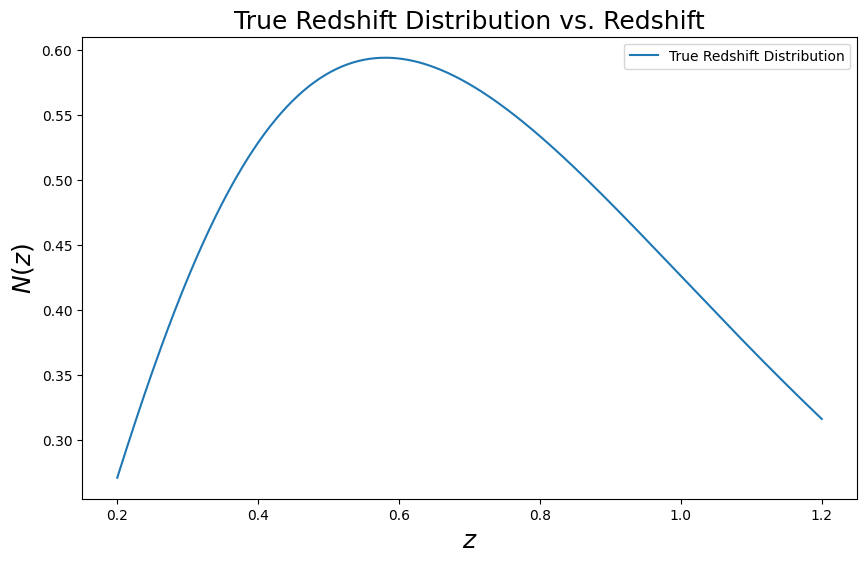

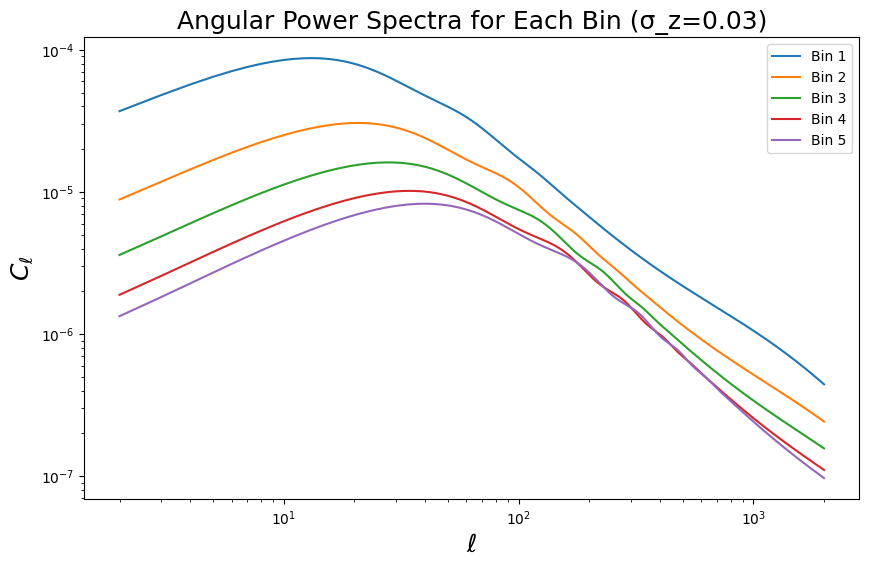

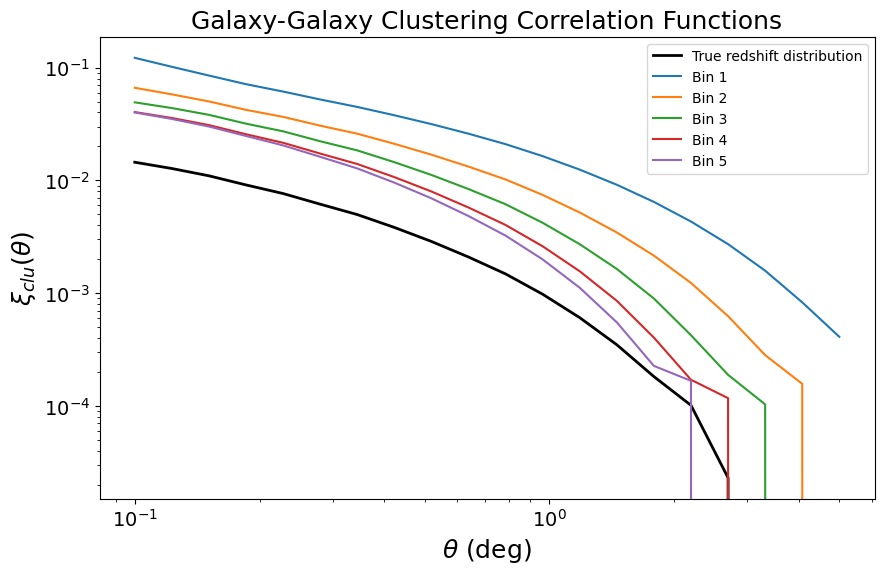

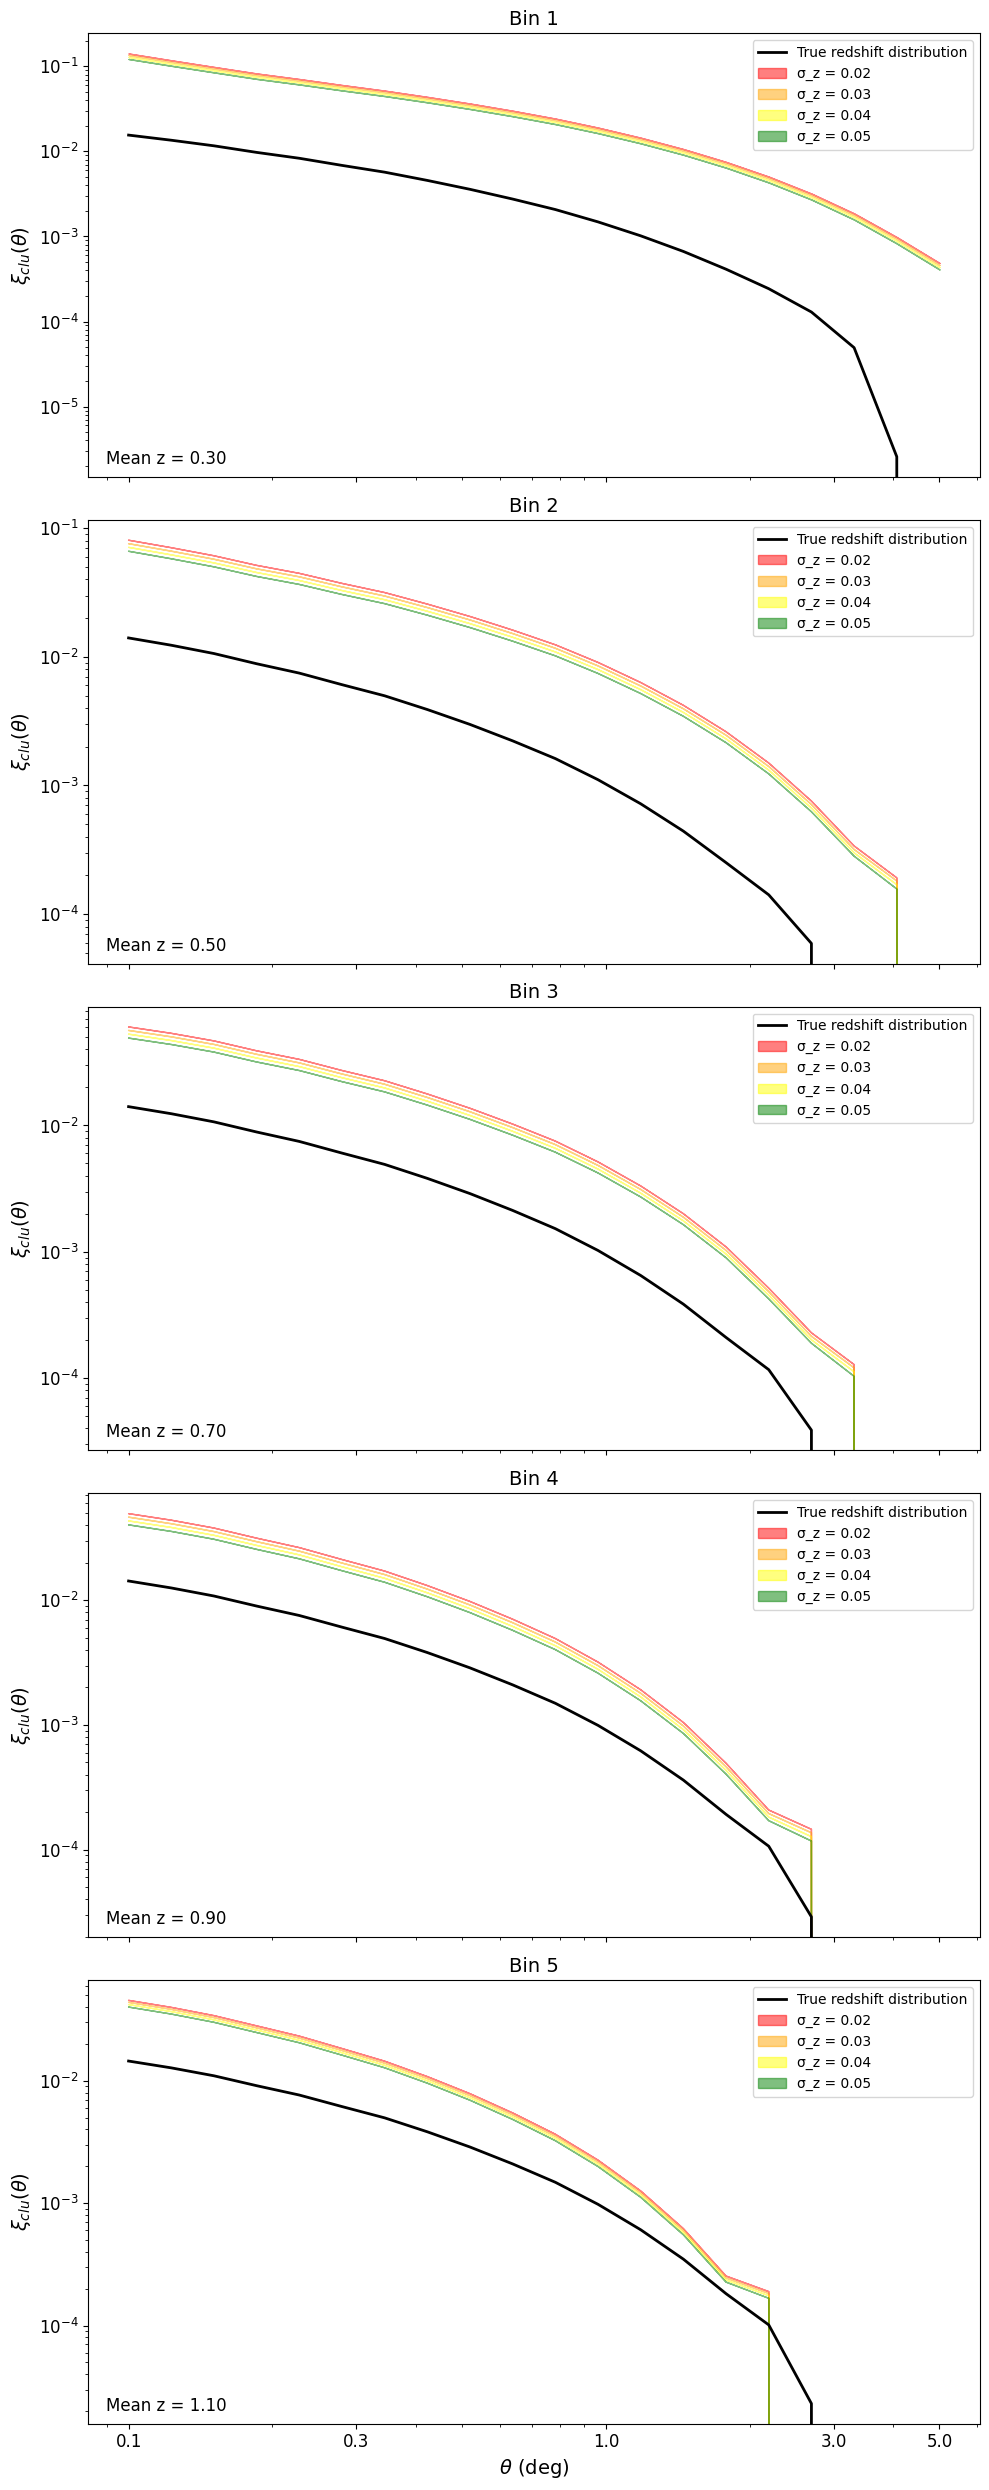

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pyccl as ccl

class SRDRedshiftDistributions:
    def __init__(self, redshift_range):
        """
        Initialize the SRDRedshiftDistributions class with a given redshift range.

        Parameters:
        redshift_range : array_like
            Array of redshift values over which the distributions will be computed.
        """
        self.redshift_range = redshift_range

    def smail_type_distribution(self, pivot_redshift, alpha, beta):
        """
        Calculate the redshift distribution using the Smail-type parameterization.

        Parameters:
        pivot_redshift : float
            Pivot redshift parameter for the Smail-type distribution.
        alpha : float
            Exponential parameter for the Smail-type distribution.
        beta : float
            Power-law parameter for the Smail-type distribution.

        Returns:
        np.array
            Array containing the computed redshift distribution.
        """
        redshift_distribution = [(z / pivot_redshift) ** beta * np.exp(-(z / pivot_redshift) ** alpha) for z in self.redshift_range]
        return np.array(redshift_distribution)

class RedshiftBinning:
    def __init__(self, z, dNdz, bin_edges, sigma):
        """
        Initialize the RedshiftBinning class with redshift data and binning parameters.
        The class calculates the contribution of each data point to binned values
        using a nested loop structure. It integrates the Gaussian PDF over the
        bin ranges to determine how much each data point contributes to each bin.
        The binned values are then normalized to sum to 1.

        Parameters:
        z : array_like
            Array of redshift values.
        dNdz : array_like
            Redshift distribution of galaxies.
        bin_edges : array_like
            Edges defining the bins in redshift space.
        sigma : array_like
            Photometric redshift uncertainties.

        Attributes:
        binned_distribution : numpy.ndarray
            Matrix to store binned redshift distributions.
        """
        self.z = z
        self.dNdz = dNdz
        self.bin_edges = bin_edges
        self.sigma = sigma
        self.binned_distribution = np.zeros((len(bin_edges) - 1, len(z)))

    def gaussian_contribution(self, z_i, sigma, bin_edge1, bin_edge2):
        """
        Calculate the contribution of z_i to the bin between bin_edge1 and bin_edge2.

        Parameters:
        z_i : float
            Redshift value of interest.
        sigma : float
            Photometric redshift uncertainty.
        bin_edge1 : float
            Lower edge of the redshift bin.
        bin_edge2 : float
            Upper edge of the redshift bin.

        Returns:
        float
        """
        norm_factor = 1 / (sigma * np.sqrt(2 * np.pi))
        integrand = lambda x: norm_factor * np.exp(-0.5 * ((x - z_i) / sigma)**2)
        contribution, _ = quad(integrand, bin_edge1, bin_edge2)
        return contribution

    def bin_data(self):
        """
        Bin the data points according to their Gaussian distributions.
        """
        for i in range(len(self.z)):
            for j in range(len(self.bin_edges) - 1):
                bin_edge1 = self.bin_edges[j]
                bin_edge2 = self.bin_edges[j + 1]
                self.binned_distribution[j, i] = self.dNdz[i] * self.gaussian_contribution(self.z[i], self.sigma[i], bin_edge1, bin_edge2)

        # Normalize the binned distribution
        for j in range(len(self.bin_edges) - 1):
            self.binned_distribution[j, :] /= np.sum(self.binned_distribution[j, :])

# Define the cosmological parameters
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Define the redshift range and distribution parameters
redshift_range = np.linspace(0.2, 1.2, 512)
beta = 2.0
alpha = 0.94
pivot_redshift = 0.26

# Instantiate the SRDRedshiftDistributions class and get the redshift distribution
srd = SRDRedshiftDistributions(redshift_range)
redshift_distribution = srd.smail_type_distribution(pivot_redshift, alpha, beta)

# Plot the true redshift distribution
plt.figure(figsize=(10, 6))
plt.plot(redshift_range, redshift_distribution, label='True Redshift Distribution')
plt.xlabel('$z$', fontsize=18)
plt.ylabel('$N(z)$', fontsize=18)
plt.title('True Redshift Distribution vs. Redshift', fontsize=18)
plt.legend()
plt.show()

# Define the bin edges and sigma (uncertainty)
bin_edges = np.linspace(0.2, 1.2, 6)
sigma_values = [0.02, 0.03, 0.04, 0.05]  # Different photometric redshift uncertainties

# Instantiate the RedshiftBinning class and bin the data
correlations = []

for sigma_z in sigma_values:
    sigma = sigma_z * np.ones_like(redshift_range)  # Photometric redshift uncertainty measure
    binning = RedshiftBinning(redshift_range, redshift_distribution, bin_edges, sigma)
    binning.bin_data()

    # Create NumberCountsTracers for each bin using the binned redshift distribution
    tracers = []
    for i in range(len(bin_edges) - 1):
        z_bin = redshift_range
        dNdz_bin = binning.binned_distribution[i]
        tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz_bin), bias=(z_bin, 1.5 * np.ones_like(z_bin)))
        tracers.append(tracer)

    # Specify angular multipoles
    ell = np.arange(2, 2000)

    # Calculate angular power spectra
    cls = []
    for tracer in tracers:
        cls.append(ccl.angular_cl(cosmo, tracer, tracer, ell))

    # Calculate the correlation function for each bin
    xi_clu_per_sigma = []
    theta_deg = np.logspace(-1, np.log10(5.), 20)  # Define angular scales in degrees
    for cl in cls:
        xi_clu = ccl.correlation(cosmo, ell=ell, C_ell=cl, theta=theta_deg, type='NN', method='FFTLog')
        xi_clu_per_sigma.append(xi_clu)
    correlations.append(xi_clu_per_sigma)

# Choose the sigma_z value to use for labeling
sigma_z_to_label = sigma_values[1]  # Change this to reflect the actual sigma value used

# Plot the angular power spectra
plt.figure(figsize=(10, 6))
for i, cl in enumerate(cls):
    plt.plot(ell, cl, label=f'Bin {i+1}')
plt.xlabel('$\\ell$', fontsize=18)
plt.ylabel('$C_\\ell$', fontsize=18)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(f'Angular Power Spectra for Each Bin (σ_z={sigma_z_to_label})', fontsize=18)
plt.show()

# Compute the true redshift distribution (no photo-z uncertainty)
true_lens_redshift_distribution_dict = {}
for index, (x1, x2) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    true_lens_redshift_distribution_dict[index] = srd.smail_type_distribution((x1 + x2) / 2, alpha, beta)

# Create the NumberCountsTracer objects for each bin with true redshift distribution
true_tracers = []
for i in range(len(bin_edges) - 1):
    z_bin = redshift_range
    dNdz = true_lens_redshift_distribution_dict[i]
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z_bin, dNdz), bias=(z_bin, 1.5 * np.ones_like(z_bin)))
    true_tracers.append(tracer)

# Calculate the angular power spectra for each bin (auto-correlations) with true redshift distribution
true_cls_matrix = np.zeros((len(bin_edges) - 1, len(ell)))
for i in range(len(bin_edges) - 1):
    true_cls_matrix[i] = ccl.angular_cl(cosmo, true_tracers[i], true_tracers[i], ell)

# Calculate the correlation function for each bin with true redshift distribution
true_correlations_matrix = np.zeros((len(bin_edges) - 1, len(theta_deg)))
for i in range(len(bin_edges) - 1):
    true_correlations_matrix[i] = ccl.correlation(cosmo, ell=ell, C_ell=true_cls_matrix[i], theta=theta_deg, type='NN', method='FFTLog')

# Plot the correlations for galaxy-galaxy clustering
plt.figure(figsize=(10, 6))
xi_clu_true = true_correlations_matrix[i]
plt.plot(theta_deg, xi_clu_true, color='black', label='True redshift distribution', linewidth=2)
for i, xi_clu in enumerate(xi_clu_per_sigma):
    plt.plot(theta_deg, xi_clu, label=f'Bin {i+1}')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xlabel(r'$\theta$ (deg)', fontsize=18)
plt.ylabel(r'$\xi_{clu} (\theta)$', fontsize=18)
plt.title('Galaxy-Galaxy Clustering Correlation Functions', fontsize=18)
plt.show()

# Plot the auto-correlations for different photo-z uncertainties
fig, axs = plt.subplots(len(bin_edges) - 1, 1, figsize=(10, (len(bin_edges) - 1) * 5), sharex=True)
if len(bin_edges) - 1 == 1:
    axs = [axs]  # Ensure axs is iterable when there's only one subplot

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo']

for i in range(len(bin_edges) - 1):
    mean_z = 0.5 * (bin_edges[i] + bin_edges[i + 1])

    # Plot the true redshift distribution correlation
    xi_clu_true = true_correlations_matrix[i]
    axs[i].plot(theta_deg, xi_clu_true, color='black', label='True redshift distribution', linewidth=2)

    # Plot the shaded regions for each photo-z uncertainty using sigma_values
    for j, sigma_z in enumerate(sigma_values):
        xi_clu = correlations[j][i]

        # Calculate the upper and lower bounds
        lower_bound = np.maximum(0, xi_clu_true - (xi_clu_true - xi_clu))
        upper_bound = xi_clu_true + (xi_clu - xi_clu_true)
        # Ensure values are valid for plotting
        valid_indices = (lower_bound > 0) & (upper_bound > 0)
        # Plot the fill_between
        axs[i].fill_between(theta_deg, lower_bound, upper_bound, color=colors[j], alpha=0.5, label=f'σ_z = {sigma_z}')

    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_ylabel(r'$\xi_{clu} (\theta)$', fontsize=14)
    axs[i].set_title(f'Bin {i+1}', fontsize=14)
    axs[i].text(0.02, 0.02, f'Mean z = {mean_z:.2f}', transform=axs[i].transAxes, fontsize=12, verticalalignment='bottom')
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].legend(loc='upper right', fontsize=10)

    # Set the x-axis labels with intervals
    axs[i].set_xticks([0.1, 0.3, 1, 3, 5])
    axs[i].get_xaxis().set_major_formatter(plt.ScalarFormatter())

axs[-1].set_xlabel(r'$\theta$ (deg)', fontsize=14)
plt.tight_layout()
plt.show()